In [855]:
# Variables for configuration
generate_pandas_profiling_reports = False
process_preprocessed_data_of_uci = False
print_pair_plots = False
drop_correlated_features = False
encode_labels = True
oneHotEncodedFeatures = ['cp','restecg', 'slope']

In [856]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib as mpl
mpl.rc('image', cmap='coolwarm')

# set pandas to show all columns of the df when using the display function
pd.set_option('display.max_columns', None)

In [857]:
# list the datasets that should be used in the current run
datasets = ["hungarian", "cleveland", "switzerland", "long-beach-va"]

In [858]:
# custom function to read the dataset into a csv formated string
# the name is used as a delimiter here because it is the last feature and common among all entrys 
def read_raw_data(file_path:str):
    with open(file_path) as file:
        file_string = file.read()
        file_string = file_string.replace("\n"," ")
        file_string = re.sub("[a-zA-Z]+ ","name\n", file_string)
        file_string = file_string.replace(" ",",")
        return file_string

In [859]:
# read the data from the specified datasets into the df 
from io import StringIO
df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(StringIO(read_raw_data("./Data/"+ dataset +".data")), header=None, sep=",")
    dataset_df['dataset'] = dataset
    df = pd.concat([df,dataset_df ], ignore_index=True)

In [860]:
df.columns=["id", "ccf", "age", "sex", "painloc", "painexer" , "relrest" , "pncaden" , "cp", "trestbps", "htn", "chol", "smoke", "cigs", "years", "fbs", "dm", "famhist", "restecg", "ekgmo", "ekgday", "ekgyr", "dig", "prop", "nitr", "pro", "diuretic", "proto", "thaldur", "thaltime", "met", "thalach", "thalrest", "tpeakbps", "tpeakbpd", "dummy", "trestbpd", "exang", "xhypo", "oldpeak", "slope", "rldv5", "rldv5e", "ca", "restckm", "exerckm", "restef", "restwm", "exeref", "exerwm", "thal", "thalsev", "thalpul", "earlobe", "cmo", "cday", "cyr", "num", "lmt", "ladprox", "laddist", "diag", "cxmain", "ramus", "om1", "om2", "rcaprox", "rcadist", "lvx1", "lvx2", "lvx3", "lvx4", "lvf", "cathef", "junk", "name", "dataset"]

In [861]:
# read the data from the specified datasets into the df
from io import StringIO
dfNew = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(StringIO(read_raw_data("./Data/"+ 'new' +".data")), header=None, sep=",")
    dataset_df['dataset'] = dataset
    dfNew = pd.concat([dfNew,dataset_df ], ignore_index=True)

# Data cleanup

In [862]:
df.dropna( axis=0,how='any', inplace =True)
df[df['age'].isnull()]

,id,ccf,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,htn,chol,smoke,cigs,years,fbs,dm,famhist,restecg,ekgmo,ekgday,ekgyr,dig,prop,nitr,pro,diuretic,proto,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,dummy,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,restckm,exerckm,restef,restwm,exeref,exerwm,thal,thalsev,thalpul,earlobe,cmo,cday,cyr,num,lmt,ladprox,laddist,diag,cxmain,ramus,om1,om2,rcaprox,rcadist,lvx1,lvx2,lvx3,lvx4,lvf,cathef,junk,name,dataset


In [863]:
if generate_pandas_profiling_reports:
    from pandas_profiling import ProfileReport
    profile = ProfileReport(df, title='Pandas Profiling Report for all features')
    profile.to_file("Pandas Profiling Report for all features.html")

# Todo Correlated Features
# TODO: in einen eigenen pipelineStep packen

In [864]:
# if cholesterin is 0 it was not measured
df['chol'] = df['chol'].replace(0, -9)
# leave the dead ones behind
# drop entries with a blood pressure of 0
df['trestbps'] = df['trestbps'].replace(0, -9)
# is a binary variable
df[df['prop'].isin([0,1]) == False] = -9

# transform proto to possible values
df['proto'] = df['proto'].replace(150, 7)
df['proto'] = df['proto'].replace(125, 8)
df['proto'] = df['proto'].replace(100, 9)
df['proto'] = df['proto'].replace(75, 10)
df['proto'] = df['proto'].replace(50, 11)

df[df['proto'].isin([*range(1,13)]) == False] = -9

In [865]:
from sklearn.preprocessing import LabelEncoder
if encode_labels:
    labelEncoder = LabelEncoder()
    df.loc[df['num'] >= 1,"num"] = 1
    df['num'] = labelEncoder.fit_transform(df['num'])

## Treatment of different scales in the datasets
### met

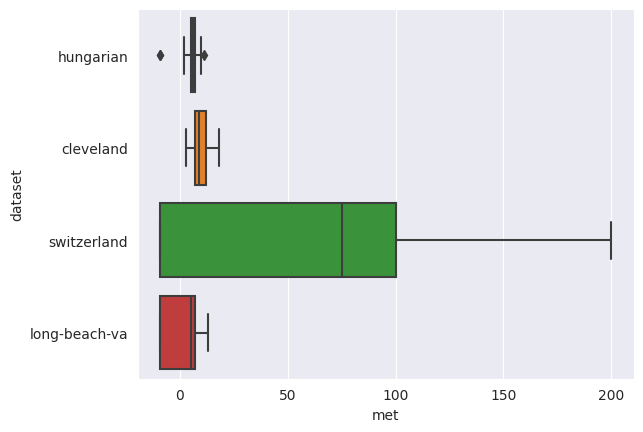

In [866]:
# plot to show the reason why we need to process this data:
sns.boxplot(x="met",y="dataset",data= df)
plt.show()

In [867]:
df.loc[df["dataset"] == "switzerland", "met"] = df.loc[df["dataset"] == "switzerland", "met"]/10

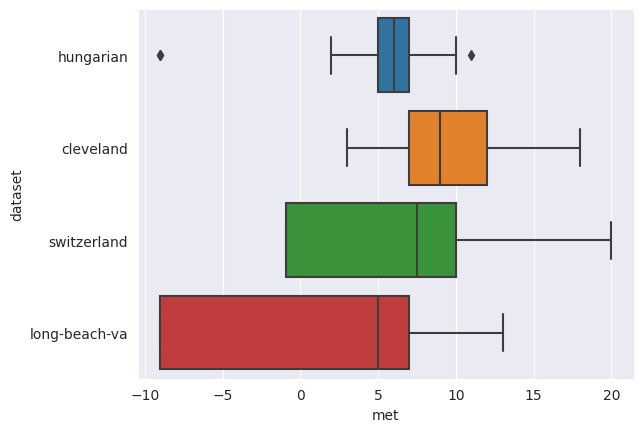

In [868]:
# plot to show the reason why we need to process this data:
sns.boxplot(x="met",y="dataset",data= df)
plt.show()

### rldv5e

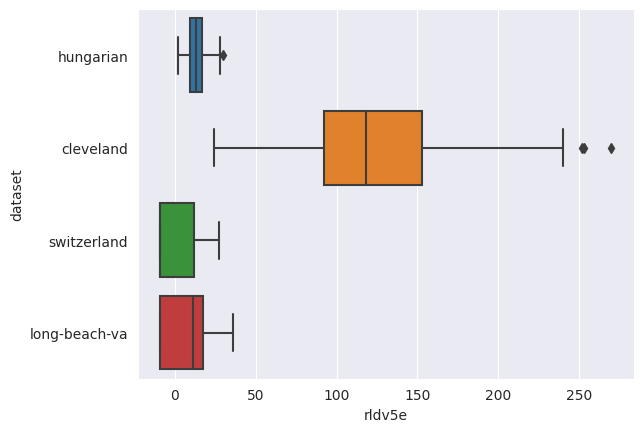

In [869]:
# plot to show the reason why we need to process this data: 
sns.boxplot(x="rldv5e",y="dataset",data= df)
plt.show()

In [870]:
df.loc[df["dataset"] == "cleveland", "rldv5e"] = df.loc[df["dataset"] == "cleveland", "rldv5e"]/10

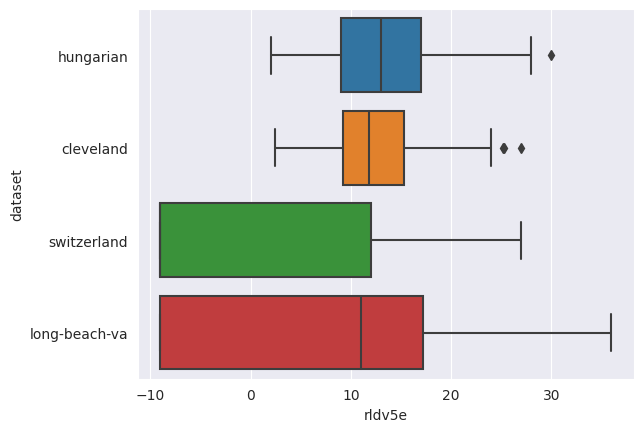

In [871]:
# plot to show the reason why we drop:
sns.boxplot(x="rldv5e",y="dataset",data= df)
plt.show()

# Drop columns

In [872]:
irrelevant_columns = [
    "id", # A id is not relevant for a model
    "ccf", # the social security number does not influence if you have a heart disease or not
    "pncaden", # sum of painlox painexer relrest -> the features are already in the dataset -> drop because it is a duplicate
    "ekgmo", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "ekgday", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "ekgyr", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cmo", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cday", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cyr", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "name" # Constant
]
df.drop(irrelevant_columns, inplace=True, axis=1)

In [873]:
unexplained_columns = [
    "restckm", # irrelevant according to the uci
    "exerckm", # irrelevant according to the uci
    "thalsev", # irrelevant according to the uci
    "thalpul", # irrelevant according to the uci
    "earlobe", # Constant
    "lvx1", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx2", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx3", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx4", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvf", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "dummy", # no description available -> from the name does not seem relevant
]
df.drop(unexplained_columns, inplace=True, axis=1)

In [874]:
hidden_identifier = [
    'lmt',      # Left main truck
    'ladprox',  # Proximal left anterior descending artery
    'laddist',  # Distal left anterior descending artery
    'diag',     # Diagonal branches
    'cxmain',   # Circumflex
    'ramus',    # Ramus intermedius
    'om1',      # First obtuse marginal branch
    'om2',      # Second obtuse marginal branch
    'rcaprox',  # Proximal right coronary artery
    'rcadist',  # Distal right coronary artery
]
df.drop(hidden_identifier, inplace=True, axis=1)

# Train the different models

In [875]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from  sklearn.naive_bayes import *

estimators=[
    # {"estimator": CatBoostClassifier(random_state=42, thread_count=-1, silent= True), "parameters": {'estimator__depth':[None] + [*range(1,200)],
    #                                                                                                  'estimator__n_estimators':range(10,1000, 100),
    #                                                                                                  'estimator__learning_rate':[0.001,0.01,0.1,0.2,0.3],
    #                                                                                                  'estimator__l2_leaf_reg':range(5,100, 5),
    #                                                                                                  'estimator__border_count':range(5,200, 5),
    #                                                                                                  'estimator__ctr_border_count':range(5,200, 5)
    #                                                                                                  }},
    # {"estimator": XGBClassifier(random_state=42, n_jobs=1), "parameters": {'estimator__max_depth': [None] + [*range(1,200)],
    #                                                                        'estimator__n_estimators': range(10,1000, 100),
    #                                                                         'estimator__learning_rate':[0.001,0.01,0.1,0.2,0.3]}},
    # {"estimator": SVC(random_state=42, tol=0.01), "parameters": {'estimator__C': [110,120,130,140,150],
    #                                                              'estimator__gamma': [0.0001, 0.001, 0.01, 0.1],
    #                                                              'estimator__degree': [3,4,5,6],
    #                                                              'estimator__kernel':['linear', 'rbf', 'poly', 'sigmoid'] }}, # '
    # {"estimator": BernoulliNB(), "parameters": {'estimator__alpha' : np.arange(0,20,0.1)}},
    # {"estimator": CategoricalNB(), "parameters": {'estimator__alpha' : np.arange(0,20,0.1)}},
    # {"estimator": ComplementNB(), "parameters": {'estimator__alpha' : np.arange(0,20,0.1),
    #                                              'estimator__norm':[True,False]}},
    # {"estimator": GaussianNB(), "parameters": {}},
    # {"estimator": MultinomialNB(), "parameters": {'estimator__alpha' : np.arange(0,20,0.1)}},
    # {"estimator": DecisionTreeClassifier(random_state=42), "parameters": {'estimator__criterion':['gini','entropy', 'log_loss'],
    #                                                                       'estimator__max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
    #                                                                       'estimator__min_samples_split': range(2,20),
    #                                                                       'estimator__min_samples_leaf': range(2,20)}},
    {"estimator": KNeighborsClassifier(), "parameters": {'estimator__n_neighbors': range(2, 100,3),
                                                         'estimator__weights': ['uniform','distance'],
                                                         'estimator__p': [1,2]}},
    # {"estimator": RandomForestClassifier(random_state=42, n_jobs=1), "parameters": {}},
    # {"estimator": SGDClassifier(max_iter=1000000), "parameters": {'estimator__loss':['log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    #                                               'estimator__penalty':['l1','l2','elasticnet'],
    #                                               'estimator__alpha' : np.arange(1,40,1)}}
]

In [876]:
from sklearn.preprocessing import *
scalers = [
    {"scaler": MaxAbsScaler(), "parameters": {}},
    {"scaler": MinMaxScaler(), "parameters": {}},
    {"scaler": Normalizer(), "parameters": {'scaler__norm': ['l1', 'l2', 'max']}},
    {"scaler": PowerTransformer(), "parameters": {}},
    {"scaler": RobustScaler(), "parameters": {'scaler__with_centering': [ True, False],'scaler__scaling': [ True, False]}},
    {"scaler": FunctionTransformer(lambda x: x), "parameters": {}},
    {"scaler": StandardScaler(), "parameters": {'scaler__with_mean': [ True, False],'scaler__with_std': [ True, False]}}
]

In [877]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
imputers = [
    {"imputer": SimpleImputer(missing_values = -9), "parameters": {'impute__strategy' : ['mean', 'median', 'most_frequent']}},
    {"imputer": KNNImputer(missing_values = -9), "parameters": {'impute__n_neighbors': range(2, 100,3)}},
]

In [878]:
# assumption the dictionaries are of equal structure
def merge_dict(dict1, dict2):
    for key, val in dict1.items():
        if type(val) == dict:
            dict1[key] = merge_dict(dict1[key], dict2[key])
        elif type(val) == list:
            if type(dict2[key]) == list:
                dict1[key] = [ *dict1[key], *dict2[key]]
            else:
                dict1[key] = [*dict1[key], dict2[key]]
        else:
            dict1[key] = [val, dict2[key]]

    return dict1

The columns smoke and years both describe whether a respondent smokes or not. Smoke does this by being binary coded, while years describes the number of years a person has smoked. Due to the high number of missing values, the columns are useless on their own. However, it is possible to enrich the smoke column with the years column.

In [879]:
class DataframeSmokeTransformer:
    def transform(self, input_df, **transform_params):
        if all(value in input_df for value in ['smoke, years']):
            input_df.loc[(input_df['smoke'].isna()) & (input_df['years'] == 0),'smoke'] = 0
            input_df.loc[(input_df['smoke'].isna()) & (input_df['years'] > 0),'smoke'] = 1

        if all(value in input_df for value in ['smoke, years']):
            input_df.loc[(input_df['smoke'].isna()) & (input_df['cigs'] == 0),'smoke'] = 0
            input_df.loc[(input_df['smoke'].isna()) & (input_df['cigs'] > 0),'smoke'] = 1
        return input_df
    def fit(self, X, y=None, **fit_params):
        return self

In [880]:
import pickle
import os
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


def classification_report_with_accuracy_score(y_true, y_pred):
    confusion_matrix_dict = {}
    for idxRow, row in np.ndenumerate(confusion_matrix(y_true, y_pred)):
        confusion_matrix_dict[str(idxRow)] = row
    current_auc_score = roc_auc_score(y_true, y_pred)
    if os.path.exists('temp.pickle'):
        with open("temp.pickle", "rb") as temp_file:
            report = pickle.load(temp_file)
            report['classification_report'] = merge_dict(report['classification_report'], classification_report(y_true, y_pred, output_dict=True))
            report["auc"].append(current_auc_score)
            report['confusion_matrix'] = merge_dict(report['confusion_matrix'], confusion_matrix_dict)
    else:
        report = {'classification_report': classification_report(y_true, y_pred, output_dict=True),
                  "auc": [current_auc_score],
                  'confusion_matrix': confusion_matrix_dict
                  }
    with open('temp.pickle', 'wb') as temp_file:
        pickle.dump(report, temp_file, protocol=pickle.HIGHEST_PROTOCOL)


    # because we need to return something
    return current_auc_score # return accuracy score

In [881]:
import json
class CustomEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if type(obj) == range:
            return [*obj]
        return super(CustomEncoder, self).default(obj)

In [882]:

import time
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


# build pipelines
# create the pipeline
pipelines = []
percentage_missing = ((df.eq(-9).sum()/len(df)*100).round(2)).to_dict()

for scaler in scalers:
    print(f"Scaler: {scaler.get('scaler').__class__.__name__}")
    for estimator in estimators:
        for imputer in imputers:
            for minimumPercentageMissingToBeDropped in range(0,101,10):
                # TODO in einen pipeline step. Aktuell nicht darin enthalten um die Entwicklung verfolgen zu können
                missing_vlaues = {key: val for key, val in percentage_missing.items() if val > minimumPercentageMissingToBeDropped}
                df_dropped = df.drop([*missing_vlaues.keys()], axis=1)
                X = df_dropped.loc[:,(df_dropped.columns!= 'num') & (df_dropped.columns != 'dataset') ]
                y = df_dropped.loc[: , (df_dropped.columns== 'num')].values.ravel()


                startTime = time.time()
                parameters =  scaler.get("parameters") | estimator.get("parameters") | imputer.get('parameters')
                oneHotEncoder = ColumnTransformer(
                    transformers=[
                         ('oneHotEncoder', OneHotEncoder(handle_unknown='infrequent_if_exist'), [value for value in oneHotEncodedFeatures if value in X.columns]),
                     ], remainder='passthrough')
                pipeline = Pipeline(steps=[
                    ('transform_smoke', DataframeSmokeTransformer()),
                    ('oneHotEncoder', oneHotEncoder),
                    ('impute', imputer.get('imputer')),
                    ('scaler', scaler.get('scaler')),
                    ('estimator', estimator.get("estimator"))
                ])
                # create the grid search instance
                grid_search_estimator = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=10, error_score='raise', n_jobs=-1, verbose= 0)
                try:
                    accuracy_best = cross_val_score(grid_search_estimator, X, y, cv=10, scoring=make_scorer(classification_report_with_accuracy_score), error_score='raise', verbose = 2, n_jobs=1)
                    grid_search_estimator.fit(X, y)
                    print(f"AUC for {estimator.get('estimator').__class__.__name__} = {accuracy_best.mean() * 100.0}")
                    display(grid_search_estimator.best_params_)
                    executionTime = (time.time() - startTime)
                except Exception as e:
                    print(f'Skipping the combination of {scaler.get("scaler").__class__.__name__} and {estimator.get("estimator").__class__.__name__} because:')
                    print(str(e))
                    output_dict = {}
                    output_dict["scaler"]= scaler.get('scaler').__class__.__name__
                    output_dict["estimator"] = estimator.get('estimator').__class__.__name__
                    output_dict["imputer"] = imputer.get('imputer').__class__.__name__
                    output_dict["reason"] = str(e)
                else:
                    output_dict = {}
                    output_dict["scaler"]= scaler.get('scaler').__class__.__name__
                    output_dict["estimator"] = estimator.get('estimator').__class__.__name__
                    output_dict["imputer"] = imputer.get('imputer').__class__.__name__

                    output_dict["minimumPercentageMissingToBeDropped"] = minimumPercentageMissingToBeDropped
                    output_dict["X_shape"] = X.shape
                    output_dict["drop_correlated_features"] = drop_correlated_features
                    output_dict["encode_labels:"] = encode_labels
                    output_dict["oneHotEncodedFeatures"] = oneHotEncodedFeatures
                    output_dict["parameters"] = parameters

                    output_dict["AUC mean"] = accuracy_best.mean() * 100
                    output_dict["Execution time in seconds"] = executionTime
                    output_dict["best_params"] = grid_search_estimator.best_params_
                    with open("temp.pickle", "rb") as temp_file:
                        report = pickle.load(temp_file)

                        output_dict["AUC"] = report['auc']
                        output_dict["classification_report"] = report['classification_report']
                        output_dict["confusion_matrix"] = report['confusion_matrix']

                finally:
                    try:
                        with open("output.json", "r") as file:
                            file_dict = json.load(file)
                            measurements  = file_dict.get('measurements')
                    except Exception as e:
                        measurements = []
                    measurements.append(output_dict)
                    with open("output.json", "w") as file:
                        json.dump({"measurements": measurements}, file, cls= CustomEncoder)
                    if os.path.exists('temp.pickle'):
                        os.remove('temp.pickle')



        print("-----------------------------------------------------------------")

Scaler: MaxAbsScaler


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   5.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   3.8s
[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   3.8s
[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   4.6s
[CV] END .................................................... total time=   3.8s
[CV] END .................................................... total time=   4.8s
[CV] END .................................................... total time=   4.5s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   41.6s finished


AUC for KNeighborsClassifier = 73.57298407167745


{'estimator__n_neighbors': 83,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'impute__strategy': 'mean'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   5.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


[CV] END .................................................... total time=   5.3s
[CV] END .................................................... total time=   5.2s
[CV] END .................................................... total time=   5.2s
[CV] END .................................................... total time=   5.2s
[CV] END .................................................... total time=   5.1s
[CV] END .................................................... total time=   4.9s
[CV] END .................................................... total time=   5.2s
[CV] END .................................................... total time=   5.2s
[CV] END .................................................... total time=   4.9s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   51.9s finished


AUC for KNeighborsClassifier = 75.61282976605277


{'estimator__n_neighbors': 83,
 'estimator__p': 1,
 'estimator__weights': 'uniform',
 'impute__strategy': 'mean'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   5.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV] END .................................................... total time=   5.1s
[CV] END .................................................... total time=   5.1s
[CV] END .................................................... total time=   5.2s
[CV] END .................................................... total time=   5.1s
[CV] END .................................................... total time=   5.1s
[CV] END .................................................... total time=   5.2s
[CV] END .................................................... total time=   5.4s
[CV] END .................................................... total time=   5.0s
[CV] END .................................................... total time=   5.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   51.4s finished


AUC for KNeighborsClassifier = 75.733300149328


{'estimator__n_neighbors': 86,
 'estimator__p': 1,
 'estimator__weights': 'distance',
 'impute__strategy': 'mean'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   5.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV] END .................................................... total time=   5.0s
[CV] END .................................................... total time=   5.2s
[CV] END .................................................... total time=   5.1s
[CV] END .................................................... total time=   5.4s
[CV] END .................................................... total time=   5.2s
[CV] END .................................................... total time=   5.2s
[CV] END .................................................... total time=   5.2s
[CV] END .................................................... total time=   5.1s
[CV] END .................................................... total time=   5.2s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   51.8s finished


AUC for KNeighborsClassifier = 75.96338974614237


{'estimator__n_neighbors': 98,
 'estimator__p': 1,
 'estimator__weights': 'distance',
 'impute__strategy': 'mean'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   5.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV] END .................................................... total time=   5.6s
[CV] END .................................................... total time=   5.6s
[CV] END .................................................... total time=   5.7s
[CV] END .................................................... total time=   5.9s
[CV] END .................................................... total time=   5.6s
[CV] END .................................................... total time=   5.8s
[CV] END .................................................... total time=   5.8s
[CV] END .................................................... total time=   6.1s
[CV] END .................................................... total time=   6.1s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   57.8s finished


AUC for KNeighborsClassifier = 75.27611996017919


{'estimator__n_neighbors': 92,
 'estimator__p': 1,
 'estimator__weights': 'distance',
 'impute__strategy': 'mean'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   6.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


[CV] END .................................................... total time=   6.0s
[CV] END .................................................... total time=   6.1s
[CV] END .................................................... total time=   6.0s
[CV] END .................................................... total time=   5.9s
[CV] END .................................................... total time=   5.8s
[CV] END .................................................... total time=   5.7s
[CV] END .................................................... total time=   5.7s
[CV] END .................................................... total time=   5.9s
[CV] END .................................................... total time=   5.8s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   59.2s finished


AUC for KNeighborsClassifier = 74.8950223992036


{'estimator__n_neighbors': 80,
 'estimator__p': 1,
 'estimator__weights': 'distance',
 'impute__strategy': 'mean'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   5.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


[CV] END .................................................... total time=   5.9s
[CV] END .................................................... total time=   5.9s
[CV] END .................................................... total time=   6.0s
[CV] END .................................................... total time=   5.8s
[CV] END .................................................... total time=   5.8s
[CV] END .................................................... total time=   5.9s
[CV] END .................................................... total time=   5.8s
[CV] END .................................................... total time=   5.9s
[CV] END .................................................... total time=   6.5s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   59.3s finished


AUC for KNeighborsClassifier = 75.96495769039322


{'estimator__n_neighbors': 71,
 'estimator__p': 1,
 'estimator__weights': 'distance',
 'impute__strategy': 'mean'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   6.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV] END .................................................... total time=   6.2s
[CV] END .................................................... total time=   6.3s
[CV] END .................................................... total time=   6.5s
[CV] END .................................................... total time=   6.3s
[CV] END .................................................... total time=   6.1s
[CV] END .................................................... total time=   6.2s
[CV] END .................................................... total time=   6.3s
[CV] END .................................................... total time=   6.2s
[CV] END .................................................... total time=   6.2s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.0min finished


AUC for KNeighborsClassifier = 77.29258337481333


{'estimator__n_neighbors': 41,
 'estimator__p': 1,
 'estimator__weights': 'distance',
 'impute__strategy': 'mean'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   6.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


[CV] END .................................................... total time=   6.2s
[CV] END .................................................... total time=   6.2s
[CV] END .................................................... total time=   6.2s
[CV] END .................................................... total time=   6.4s
[CV] END .................................................... total time=   6.2s
[CV] END .................................................... total time=   6.2s
[CV] END .................................................... total time=   6.1s
[CV] END .................................................... total time=   6.2s
[CV] END .................................................... total time=   6.2s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.0min finished


AUC for KNeighborsClassifier = 76.56758337481332


{'estimator__n_neighbors': 38,
 'estimator__p': 1,
 'estimator__weights': 'distance',
 'impute__strategy': 'mean'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   6.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV] END .................................................... total time=   6.4s
[CV] END .................................................... total time=   6.3s
[CV] END .................................................... total time=   6.3s
[CV] END .................................................... total time=   6.3s
[CV] END .................................................... total time=   6.5s
[CV] END .................................................... total time=   6.4s
[CV] END .................................................... total time=   6.4s
[CV] END .................................................... total time=   6.3s
[CV] END .................................................... total time=   6.4s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished


AUC for KNeighborsClassifier = 76.962493777999


{'estimator__n_neighbors': 38,
 'estimator__p': 1,
 'estimator__weights': 'distance',
 'impute__strategy': 'mean'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   6.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV] END .................................................... total time=   6.4s
[CV] END .................................................... total time=   6.5s
[CV] END .................................................... total time=   6.5s
[CV] END .................................................... total time=   6.5s
[CV] END .................................................... total time=   6.5s
[CV] END .................................................... total time=   6.5s
[CV] END .................................................... total time=   6.4s
[CV] END .................................................... total time=   6.4s
[CV] END .................................................... total time=   6.4s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished


AUC for KNeighborsClassifier = 77.112493777999


{'estimator__n_neighbors': 38,
 'estimator__p': 1,
 'estimator__weights': 'distance',
 'impute__strategy': 'mean'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  37.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.9s remaining:    0.0s


[CV] END .................................................... total time=  37.9s
[CV] END .................................................... total time=  39.0s
[CV] END .................................................... total time=  40.2s
[CV] END .................................................... total time=  39.1s
[CV] END .................................................... total time=  39.4s
[CV] END .................................................... total time=  39.3s
[CV] END .................................................... total time=  39.3s
[CV] END .................................................... total time=  41.3s
[CV] END .................................................... total time=  40.6s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  6.6min finished


AUC for KNeighborsClassifier = 73.57298407167745


{'estimator__n_neighbors': 83,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'impute__n_neighbors': 2}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 2.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s


[CV] END .................................................... total time= 2.7min
[CV] END .................................................... total time= 2.6min
[CV] END .................................................... total time= 2.7min
[CV] END .................................................... total time= 2.5min
[CV] END .................................................... total time= 2.5min
[CV] END .................................................... total time= 2.6min
[CV] END .................................................... total time= 2.4min
[CV] END .................................................... total time= 2.4min
[CV] END .................................................... total time= 2.0min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 24.9min finished


AUC for KNeighborsClassifier = 76.2776505724241


{'estimator__n_neighbors': 86,
 'estimator__p': 1,
 'estimator__weights': 'uniform',
 'impute__n_neighbors': 14}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 3.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min remaining:    0.0s


[CV] END .................................................... total time= 3.1min
[CV] END .................................................... total time= 3.0min
[CV] END .................................................... total time= 2.9min
[CV] END .................................................... total time= 2.9min
[CV] END .................................................... total time= 2.7min
[CV] END .................................................... total time= 2.7min
[CV] END .................................................... total time= 2.8min
[CV] END .................................................... total time= 2.7min
[CV] END .................................................... total time= 2.4min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 28.3min finished


AUC for KNeighborsClassifier = 76.8491538078646


{'estimator__n_neighbors': 89,
 'estimator__p': 1,
 'estimator__weights': 'distance',
 'impute__n_neighbors': 8}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 3.4min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s


[CV] END .................................................... total time= 3.5min
[CV] END .................................................... total time= 3.4min
[CV] END .................................................... total time= 3.6min
[CV] END .................................................... total time= 3.4min
[CV] END .................................................... total time= 3.1min
[CV] END .................................................... total time= 3.2min


KeyboardInterrupt: 

In [ ]:
parameters =  scaler.get("parameters") | estimator.get("parameters") | imputer.get('parameters')
oneHotEncoder = ColumnTransformer(
    transformers=[
        ('oneHotEncoder', OneHotEncoder(handle_unknown='infrequent_if_exist'), [value for value in oneHotEncodedFeatures if value in X.columns]),
    ], remainder='passthrough')
pipeline = Pipeline(steps=[
    ('transform_smoke', DataframeSmokeTransformer()),
    ('oneHotEncoder', oneHotEncoder),
    ('impute', imputer.get('imputer')),
    ('scaler', scaler.get('scaler')),
    ('estimator', estimator.get("estimator"))
])
# create the grid search instance
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=10, error_score='raise', n_jobs=-1, verbose= 0)
grid_search_estimator.fit(X,y)

In [ ]:
if not process_preprocessed_data_of_uci:
    raise SystemExit("So Feierabend Emma")

# XGBoost Test

In [ ]:
from xgboost import plot_importance

classifier = XGBClassifier(learning_rate = 0.01, n_estimators=510)
classifier.fit(X,y)
# plot feature importance
plot_importance(classifier)
plt.show()

# Tests with the preprocessed data by the UCI

In [ ]:
import pandas as pd 
datasets = ["hungarian", "cleveland", "switzerland", "va"]
df_processed = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv("./Data/processed."+ dataset +".data", header=None, sep=",")
    dataset_df['dataset'] = dataset
    df_processed = pd.concat([df_processed,dataset_df ], ignore_index=True)
df_processed.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num', 'dataset']
df_processed = df_processed.replace('?', float('nan'))


In [ ]:
df_processed[['trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']] = df_processed[['trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']].apply(pd.to_numeric)

In [ ]:
(df_processed.loc[ : , df_processed.columns != 'dataset'].isna()).join(df_processed['dataset']).groupby("dataset").sum()

In [ ]:
df_processed.drop(["slope", "ca","thal"], inplace=True, axis=1)

In [ ]:
print(f"Shape before drop of NaN containing rows: {df_processed.shape}")
df_processed.dropna(inplace=True, axis=0, how='any')
print(f"Shape after drop of NaN containing rows: {df_processed.shape}")

In [ ]:
df_processed.shape

In [ ]:
df_processed.head()

In [ ]:
df_processed.describe()

In [ ]:
if generate_pandas_profiling_reports:
    profile = ProfileReport(df_processed, title='Pandas Profiling Report for the features processed by the UCI')
    profile.to_file("Pandas Profiling Report for the features processed by the UCI.html")

In [ ]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
df_processed.loc[df_processed['num'] >= 1,"num"] = 1
df_processed['num'] = labelEncoder.fit_transform(df_processed['num'])

In [ ]:
X = df_processed.loc[:,(df_processed.columns!= 'num') & (df_processed.columns != 'dataset')]
y = df_processed['num']

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from statistics import mean
for scaler in scalers:
    print(f'Current Sclaer: {scaler.__class__.__name__}')
    for estimator in estimators_and_hyperparameters:
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        try:
            X_trans = scaler.fit_transform(X)
            scores = cross_val_score(estimator[0], X_trans, y, scoring='f1',cv=skf, n_jobs=-1)
            print(f'F1 score for {estimator[0].__class__.__name__}: {mean(scores)}')
        except Exception as e:
            print(e)
            print(f'Skipping the combination of {scaler.__class__.__name__} and {estimator[0].__class__.__name__}')
    print('-----------------------------------------------------------------')
print(f'Current Sclaer: NoScaler')
for estimator in estimators_and_hyperparameters:
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    try:
        X_trans = X
        scores = cross_val_score(estimator[0], X_trans, y, scoring='f1',cv=skf, n_jobs=-1)
        print(f'F1 score for {estimator[0].__class__.__name__}: {mean(scores)}')
    except Exception as e:
        print(e)
        print(f'Skipping the combination of NoScaler and {estimator[0].__class__.__name__}')
print('-----------------------------------------------------------------')

In [ ]:
# Tests with the preprocessed data by the UCI includeing the reprocessed data

In [ ]:
import pandas as pd 
datasets = ["hungarian", "cleveland", "switzerland", "va"]
df_processed = pd.DataFrame()
for dataset in datasets:
    if dataset != "hungarian":
        dataset_df = pd.read_csv("./Data/processed."+ dataset +".data", header=None, sep=",")
        dataset_df['dataset'] = dataset
        df_processed = pd.concat([df_processed,dataset_df ], ignore_index=True)
with open("Data/reprocessed.hungarian.data") as file:
    dataString = file.read()
    dataString = dataString.replace(" ",",")
    dataset_df = pd.read_csv(StringIO(dataString), header=None, sep=",")
    dataset_df['dataset'] = dataset
df_processed = pd.concat([df_processed,dataset_df ], ignore_index=True)
df_processed.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num', 'dataset']
df_processed = df_processed.replace('?', float('nan'))

In [ ]:
df_processed[['trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']] = df_processed[['trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']].apply(pd.to_numeric)

In [ ]:
df_processed

In [ ]:
if generate_pandas_profiling_reports:
    profile = ProfileReport(df_processed, title='Pandas Profiling Report for the features processed by the UCI + reprocessed hungarian')
    profile.to_file("Pandas Profiling Report for the features processed by the UCI + reprocessed hungarian.html")